In [1]:
import os
import glob
import itertools
import json
import importlib
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm
import tifffile as tf

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

/home/julianarhee/anaconda2/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [5]:
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.extraction.rois as roiutils

import analyze2p.correlations as cr

In [6]:
%matplotlib notebook

# Plotting

In [8]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)

#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

# Source

In [317]:
experiment = 'gratings'
responsive_test='nstds'
# ---------------------------------------------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_stds=2.5
n_bootstrap_iters=500
n_resamples=20
print(responsive_test, responsive_thr)

#### Responsive params
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                            responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters) #, 
#                             n_resamples=n_resamples)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)

nstds 10.0
traces001|fit-dff_responsive-nstds-2.50-thr10.00_boot-500


# Output dir

In [318]:
dst_dir = os.path.join(aggregate_dir, 'correlations', 
                       'gratings_%s_%s' % (response_type, responsive_test))
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_nstds


In [319]:
#### Set current output dir
curr_dst_dir = os.path.join(dst_dir, 'pref_theta')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_nstds/pref_theta


# Load metadata

In [320]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# cells, missing_seg = aggr.get_cells_by_area(sdata, return_missing=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()

all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())


/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
|    |   visual_area |
|:---|--------------:|
| Li |            16 |
| Lm |            10 |
| V1 |             9 |


# Load all fits

In [321]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, 
                            fit_desc=ori_fit_desc, return_missing=True) 
gdata = hutils.split_datakey(gdata)
gdata['tf'] = gdata['sf']*gdata['speed'] # fit params
# Assign "preferred theta" for tested values
tested_thetas = np.arange(0, 360, 45)
theta_vals = np.arange(0, 360+45, 45)
gdata['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)==np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                            for t in gdata['theta_pref']]
gdata['tested_theta'] = gdata['tested_theta'].astype(float)

... [20190314_JC070_fov1] No ori_dir
... [20190315_JC070_fov2] No ori_dir
... [20190319_JC067_fov1] No ori_dir
... [20190321_JC070_fov2] No ori_dir
... [20190522_JC089_fov1] No ori_dir
... [20190527_JC092_fov3] No ori_dir
... [20190602_JC091_fov1] No ori_dir
... [20190606_JC091_fov1] No ori_dir
... [20190607_JC091_fov1] No ori_dir
... [20190609_JC099_fov1] No ori_dir
... [20190612_JC099_fov1] No ori_dir
... [20190614_JC091_fov1] No ori_dir
... [20190617_JC099_fov1] No ori_dir
... [20191018_JC113_fov1] No ori_dir
... [20191105_JC117_fov1] No ori_dir
... [20191111_JC120_fov1] No ori_dir
... [20190306_JC061_fov2] No ori_dir
... [20190512_JC083_fov1] No ori_dir
... [20190513_JC078_fov1] No ori_dir
... [20190517_JC083_fov1] No ori_dir
... [20190525_JC084_fov1] No ori_dir
... [20190603_JC080_fov1] No ori_dir
... [20190618_JC097_fov1] No ori_dir
... [20190627_JC091_fov1] No ori_dir
... [20191105_JC117_fov1] No ori_dir
... [20191111_JC120_fov1] No ori_dir
... [20190511_JC083_fov1] No ori_dir
.

ValueError: No objects to concatenate

In [14]:
print("Filter by combined R2:")
print(gdata[gdata['r2comb']>=0.5][['visual_area', 'datakey', 'cell']]\
    .drop_duplicates()['visual_area'].value_counts().to_markdown())

print("Filter by Goodness-of-Fit thr:")
print(gdata[gdata['gof']>=0.5][['visual_area', 'datakey', 'cell']]\
    .drop_duplicates()['visual_area'].value_counts().to_markdown())


Filter by combined R2:
|    |   visual_area |
|:---|--------------:|
| V1 |           667 |
| Lm |           318 |
| Li |           209 |
Filter by Goodness-of-Fit thr:
|    |   visual_area |
|:---|--------------:|
| V1 |           443 |
| Lm |           227 |
| Li |            98 |


In [15]:
best_gof_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
                    .transform(max) == gdata['gof']
assert gdata.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
                    .count().max().max()==1
bestg = gdata.loc[best_gof_ixs].copy()
bestg.groupby(['visual_area']).count()

,response_pref,response_null,theta_pref,sigma,response_offset,asi,dsi,circvar_asi,circvar_dsi,r2,...,gof,sf,size,speed,datakey,animalid,fov,session,tf,tested_theta
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,349,349,349,349,349,349,349,349,349,349,...,349,349,349,349,349,349,349,349,349,349
Lm,422,422,422,422,422,422,422,422,422,422,...,422,422,422,422,422,422,422,422,422,422
V1,861,861,861,861,861,861,861,861,861,861,...,861,861,861,861,861,861,861,861,861,861


In [17]:
# Unique datasets, get dsets with most ncells pass
min_ncells=10
gof_thr=0.5
drop_repeats=True
counts = bestg[bestg['gof']>gof_thr][['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area', 'datakey']).count().reset_index()
u_dkeys = aggr.drop_repeats(counts)   
FITS = pd.concat([g for (va, dk), g in bestg.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])
print(FITS[['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area']).count())

             datakey  cell
visual_area               
Li               249   249
Lm               411   411
V1               861   861


# Get RF fits

In [20]:
import analyze2p.decoding as dec

In [21]:
# Load RF data
response_type='dff'
do_spherical_correction=False
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                       do_spherical_correction=do_spherical_correction)
rfdf = dec.get_rfdf(CELLS, sdata, response_type=response_type,
                       do_spherical_correction=do_spherical_correction)
print(rfdf['experiment'].unique())

N dpaths: 62, N unfit: 0
N datasets included: 67, N sessions excluded: 4
['average_rfs']


In [22]:
assigned_cells, rf_meta = aggr.select_assigned_cells(CELLS, sdata,  
                                  experiments=['rfs', 'rfs10'])
RF0 = rfutils.aggregate_rfdata(rf_meta, assigned_cells, 
                                  fit_desc=rf_fit_desc, 
                                  reliable_only=False, pass_criterion='most')


N dpaths: 62, N unfit: 0
N datasets included: 67, N sessions excluded: 4


In [23]:
r_=[]
for (va, dk), rfs_ in RF0.groupby(['visual_area', 'datakey']):
    if va in ['V1', 'Lm']:
        if 'rfs' in rfs_['experiment'].values:
            r_.append(rfs_[rfs_['experiment']=='rfs'])
    elif va=='Li':
        if 'rfs10' in rfs_['experiment'].values:
            r_.append(rfs_[rfs_['experiment']=='rfs10'])
tmprfs = pd.concat(r_, axis=0, ignore_index=True)
tmprfs.shape

(1229, 27)

In [251]:
pass_gof=True
# if pass_gof:
#     gfits = FITS[FITS['gof']>0.5].copy()
# else:
#     gfits = FITS.copy()
if pass_gof:
    gfits = bestg[bestg['gof']>0.5].copy()
else:
    gfits = bestg.copy()
gof_str = 'gof%.2f' % gof_thr if pass_gof else 'allfit'

In [252]:
rfs_now = tmprfs.copy()
same_col_names = np.intersect1d(gfits.columns.tolist(), rfs_now.columns.tolist())
same_col_names

array(['cell', 'datakey', 'r2', 'visual_area'], dtype='<U15')

In [253]:
rfs_now = rfs_now.rename(columns={'r2': 'r2_rf'})
gfits = gfits.rename(columns={'r2': 'r2_dir'})

merge_cols=['visual_area', 'datakey', 'cell']
GRFS = pd.merge(gfits, rfs_now, on=merge_cols, how='inner')

GRFS['rf_theta_deg'] = [np.rad2deg(i) for i in GRFS['theta_Mm_c'].values]

GRFS.groupby(['visual_area'])['cell'].count()


visual_area
Li     43
Lm     64
V1    169
Name: cell, dtype: int64

In [254]:
gratrf_counts = GRFS.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
gratrf_ukeys = aggr.drop_repeats(gratrf_counts)

finaldf = GRFS.copy()

# finaldf = pd.concat([g for (va, dk), g in GRFS.groupby(['visual_area', 'datakey'])
#                   if (va, dk) in gratrf_ukeys])
# finaldf['rf_theta_deg'] = [np.rad2deg(i) for i in finaldf['theta_Mm_c'].values]
# finaldf[finaldf['gof']>0.5].groupby(['visual_area']).count()

In [255]:
df = aggr.add_roi_positions(finaldf.copy())

In [256]:
import analyze2p.correlations as cr

In [257]:
def smallest_signed_angle(x, y, TAU=360):
    a = (x - y) % TAU
    b = (y - x) % TAU
    return -a if a < b else b

def get_pw_angular_dist(df_, tau=180, in_name='input', out_name='output'):
    col_pairs = list(itertools.combinations(df_['cell'], 2))
    pairdf = pd.DataFrame(['%i_%s' % (a, b) for a, b \
                           in col_pairs], columns=['neuron_pair'])
    pairdf['cell_1'] = [a for a, b in col_pairs]
    pairdf['cell_2'] = [b for a, b in col_pairs]
    pairdf[out_name] = [abs(smallest_signed_angle(\
                              float(df_[df_['cell']==a][in_name]), 
                               float(df_[df_['cell']==b][in_name]), TAU=tau)) \
                        for a, b in col_pairs]
    return pairdf

In [294]:
smallest_signed_angle(0, 225, TAU=360)

-135

In [279]:
smallest_signed_angle(0, 150, TAU=180)

-30

In [295]:
min_ncells=5
a_=[]
for (va, dk), df_ in df.groupby(['visual_area', 'datakey']):
    if len(df_['cell'].unique())<min_ncells:
        continue
    osi_diff = get_pw_angular_dist(df_, tau=360,
                                   in_name='theta_pref', out_name='pref_theta_diff')
    rf_diff = get_pw_angular_dist(df_, tau=180,
                                  in_name='rf_theta_deg', out_name='rf_angle_diff')
    diffs_ = pd.merge(osi_diff, rf_diff, on=['neuron_pair', 'cell_1', 'cell_2'])
#     adist = cr.get_pw_distance(diffs_, df_, xcoord='ml_pos', ycoord='ap_pos', 
#                              label='cortical_distance')
    adist = cr.get_pw_distance(diffs_, df_, xcoord='x0', ycoord='y0', 
                             label='rf_distance')
    adist['visual_area'] = va
    adist['datakey'] = dk
    adist['n_cells'] = len(df_['cell'].unique())
    a_.append(adist)
angdists = pd.concat(a_, axis=0, ignore_index=True)


In [296]:
#adist.head()
compare_cols = ['pref_theta_diff', 'rf_angle_diff', 
                'rf_distance', 'cortical_distance']

<IPython.core.display.Javascript object>


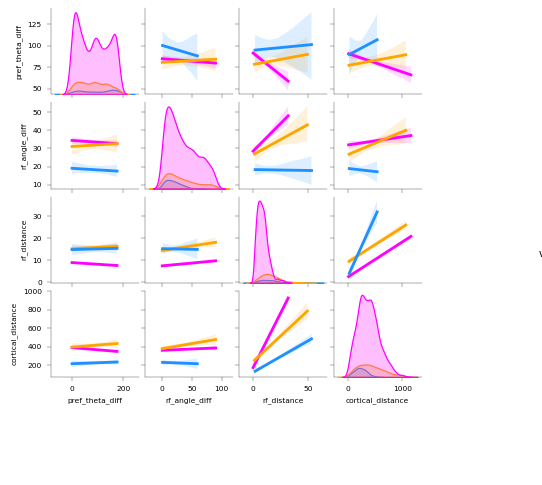

In [297]:
%matplotlib notebook
sns.pairplot(angdists, vars=compare_cols, height=1.5,
            hue='visual_area', palette=area_colors, 
             plot_kws={ 'scatter': False, 'scatter_kws': {'s': 1}},
            hue_order=visual_areas, kind='reg', )
pl.subplots_adjust(bottom=0.3, right=0.7)

In [298]:
print(angdists.groupby(['visual_area'])['cortical_distance'].max())

angdists0 = angdists[angdists['cortical_distance']<=500].copy()

visual_area
Li     535.671223
Lm    1066.254662
V1    1160.609688
Name: cortical_distance, dtype: float64


In [309]:
# ------------------------------
cmap='viridis'
custom_bins=False
# ------------------------------
# Bin data
to_quartile='rf_distance'
n_bins=20
use_quartile=False
# ---------------------------------
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                            cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(angdists0, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
bcorrs = bcorrs.dropna()
# Add bin value to df
bin_values = bcorrs.groupby(['binned_%s' % to_quartile])[to_quartile].median()
bin_lut = dict((k, v) for k, v in zip(bin_labels, bin_values))
bcorrs['bin_value'] = [bin_lut[b] for b in bcorrs['binned_%s' % to_quartile]]

# Count N pairs in each bin
pairs_per_bin = bcorrs.groupby(['visual_area', 'binned_%s' % to_quartile])\
                ['neuron_pair'].count().reset_index()\
                .rename(columns={'neuron_pair': 'n_pairs'})
pairs_per_bin['bin_value'] = [bin_lut[b] for b \
                               in pairs_per_bin['binned_%s' % to_quartile]]
# bin_column='bin_value'

<IPython.core.display.Javascript object>


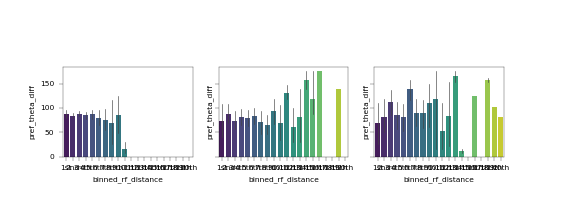

In [310]:
y_var='pref_theta_diff'
x_var = 'binned_%s' % to_quartile

n_iter=int(np.random.rand(1)[0]*500)
min_npairs = 5
n_iter=100

xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'
cnt_grouper = [x_var] 

fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in bcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    fov_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    # plot
    sns.barplot(x=x_var, y=y_var, data=cc0, ax=ax, palette='viridis',
               estimator=np.mean, errwidth=0.5)
#     ax.scatter(x=to_quartile, y=y_var, data=fov_cc, 
#                 s=5, color='k')
#     res_, xvals, yvals = cr.fit_decay_on_binned(fov_cc, use_binned=False,
#                                             normalize_x=True, func='halflife',
#                                             estimator='median',
#                                             metric=metric,
#                                             to_quartile=to_quartile,
#                                             return_inputs=True)
#     if all(res_.isnull()):
#         print("BINNED, no fit: %s" % va)
#         label='no fit'
#     else:
#         fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
#         label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
#                         % (va, res_.tau, res_.init, res_.constant, res_.R2)
#         ax.plot(xvals, fit_y, color='r', label=label)

#     ax.set_xlabel(xlabel)
#     ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=2)
       #ax.set_title(va)
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7)


<IPython.core.display.Javascript object>


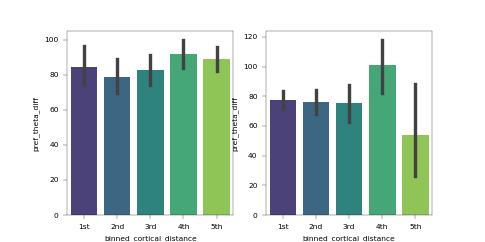

In [311]:
near_ = angdists[angdists['cortical_distance']<=250].copy()
far_ = angdists[angdists['cortical_distance']>=500].copy()
y_var = 'pref_theta_diff'

# Bin data
to_quartile='cortical_distance'
n_bins=5
use_quartile=False
# ---------------------------------
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                            cmap=cmap)
near_, bins_ = cr.bin_column_values(near_, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
far_, bins_ = cr.bin_column_values(far_, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
fig, axn = pl.subplots(1, 2, figsize=(6,3))
ax=axn[0]
sns.barplot(x='binned_%s' % to_quartile, y=y_var, data=near_, ax=ax,
           palette='viridis')
ax=axn[1]
sns.barplot(x='binned_%s' % to_quartile, y=y_var, data=far_, ax=ax,
           palette='viridis')
pl.subplots_adjust(bottom=0.2, right=0.8)

In [312]:
angdists['pref_theta_diff']

0         7.346939
1        88.163265
2         7.346939
3       139.591837
4         0.000000
           ...    
2770    146.938776
2771    168.979592
2772    154.285714
2773    161.632653
2774     44.081633
Name: pref_theta_diff, Length: 2775, dtype: float64

In [314]:
x_var='rf_distance'
print(angdists.groupby(['visual_area'])[x_var].max())


curr_df = angdists[angdists[x_var]<=50].copy()

visual_area
Li    53.261005
Lm    49.531952
V1    31.980850
Name: rf_distance, dtype: float64


In [315]:
near_lim = 20
far_lim = 30
near_ = curr_df[curr_df[x_var]<near_lim].copy()
far_ = curr_df[curr_df[x_var]>far_lim].copy()

# Bin data
to_quartile='pref_theta_diff'
n_bins=5
use_quartile=False
# ---------------------------------
# bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
#                                             cmap=cmap)
bins=[0, 45, 90, 135, 180]
bin_labels=bins[0:-1]

bin_labels=bins[0:-1]
near_['binned_%s' % to_quartile], bin_edges = pd.cut(near_[to_quartile], \
                                                bins, labels=None, retbins=True)
near_['distance_label'] = 'd<%i um' % near_lim
near_['distance'] = 'near'

far_['binned_%s' % to_quartile], bin_edges = pd.cut(far_[to_quartile], \
                                                bins, labels=None, retbins=True)
far_['distance_label'] = 'd>%i um' % far_lim
far_['distance'] = 'far'


dists = pd.concat([near_, far_], axis=0, ignore_index=True)

# near_, bins_ = cr.bin_column_values(near_, to_quartile=to_quartile, 
#                      use_quartile=use_quartile, return_bins=True,
#                      n_bins=n_bins, bins=bins, labels=bin_labels)
# far_, bins_ = cr.bin_column_values(far_, to_quartile=to_quartile, 
#                      use_quartile=use_quartile, return_bins=True,
#                      n_bins=n_bins, bins=bins, labels=bin_labels)

<IPython.core.display.Javascript object>


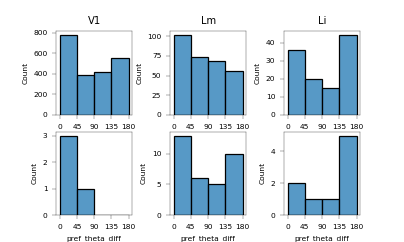

In [316]:
fig, axn = pl.subplots(2, 3, figsize=(5,3))
for va, vg in dists.groupby('visual_area'):
    ai = visual_areas.index(va)
    ax=axn[0, ai]
    ax.set_title(va)
    sns.histplot(x='pref_theta_diff', data=vg[vg['distance']=='near'], ax=ax, bins=bins)
    ax=axn[1, ai]
    sns.histplot(x='pref_theta_diff', data=vg[vg['distance']=='far'], ax=ax, bins=bins)

for ax in axn.flat:
    ax.set_xticks(bins)
pl.subplots_adjust(bottom=0.2, right=0.8, wspace=0.5)

In [162]:
cnts_near = near_.groupby(['visual_area', 'binned_%s' % to_quartile])['neuron_pair']\
                 .count().reset_index()
cnts_near['distance'] = 'near'
cnts_far = far_.groupby(['visual_area', 'binned_%s' % to_quartile])['neuron_pair']\
                 .count().reset_index()
cnts_far['distance'] = 'far'

cnts = pd.concat([cnts_far, cnts_near], axis=0)
cnts

,visual_area,binned_pref_theta_diff,neuron_pair,distance
0,Li,"(0, 45]",97,far
1,Li,"(45, 90]",40,far
2,Li,"(90, 135]",0,far
3,Li,"(135, 180]",0,far
4,Lm,"(0, 45]",150,far
5,Lm,"(45, 90]",127,far
6,Lm,"(90, 135]",0,far
7,Lm,"(135, 180]",0,far
8,V1,"(0, 45]",990,far
9,V1,"(45, 90]",641,far


<IPython.core.display.Javascript object>


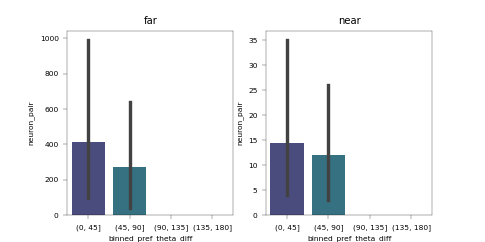

In [163]:
fig, axn = pl.subplots(1, 2, figsize=(6,3))
for ax, (cd, cg) in zip(axn.flat, cnts.groupby('distance')):
    sns.barplot(x='binned_%s' % to_quartile, y='neuron_pair', data=cg, ax=ax,
           palette='viridis')
    ax.set_title(cd)
pl.subplots_adjust(bottom=0.2, right=0.8)

In [ ]:
va='V1' 
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_distance', y='rf_angle_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 0.5, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.1, left=0.05,top=0.8)

In [ ]:
va='V1'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_distance', y='pref_theta_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 0.5, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.1, left=0.05,top=0.8)

In [ ]:
va='V1'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_angle_diff', y='pref_theta_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 0.5, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.1, left=0.05,top=0.8)

In [ ]:
va='Li'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_angle_diff', y='pref_theta_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 1, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.2, left=0.05,top=0.8)

In [ ]:
va='Li'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_distance', y='pref_theta_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 1, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.2, left=0.05,top=0.8)

In [ ]:
va='Li'
df_ = angdists[(angdists.visual_area==va)].copy()
fg = sns.lmplot(x='rf_distance', y='rf_angle_diff', data=df_, 
            col='datakey', height=2, col_wrap=4, 
            scatter_kws={'s': 1, 'color': 'k'},
            line_kws={'color': area_colors[va]})
fg.fig.text(0, 0.95, va, fontsize=12)
for ax in fg.axes:
    ax.set_ylim([0, 90])
pl.subplots_adjust(bottom=0.2, left=0.05,top=0.8)

### Signal corrs

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

{0: 'r', 315: 'r', 180: 'b', 225: 'b'}


<IPython.core.display.Javascript object>


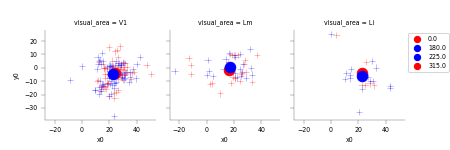

V1: nasal=(24.2, -4.1) | temporal (22.3, -4.9)
Lm: nasal=(16.7, -1.8) | temporal (17.2, 0.8)
Li: nasal=(22.8, -3.6) | temporal (22.6, -6.4)


In [311]:
# 0: Nasal, 180: Temporal
# 90: Upward, 270: Downward
nasal_color = 'r'
temporal_color='b'
nasal_ = [0, 315]
temporal_ = [180, 225]

theta_colors = dict((k, nasal_color) for k in nasal_)
theta_colors.update(dict((k, temporal_color) for k in temporal_))
print(theta_colors)

curr_oris = theta_colors.keys() #[0, 180]

currdata = DF[(DF['dsi']>=0.1) & (DF['tested_theta'].isin(curr_oris))].copy()

fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, height=2,
                   data=currdata)
fg.map(sns.scatterplot, 'x0', 'y0', 'tested_theta', #palette=theta_colors,
      alpha=0.5, palette=theta_colors, marker='+', facecolor='none')
# sns.scatterplot(x='x0', y='y0', hue='tested_theta', data=df_, ax=ax,
#                palette=theta_colors)
pl.legend(loc='upper left', bbox_to_anchor=(1,1))
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

for ai, va in enumerate(visual_areas):
    ax = fg.axes.flat[ai]
    df_ = currdata[currdata.visual_area==va].copy()
    cx_n, cy_n = hutils.CoM(df_[df_['tested_theta'].isin(nasal_)][['x0', 'y0']])
    cx_t, cy_t = hutils.CoM(df_[df_['tested_theta'].isin(temporal_)][['x0', 'y0']])
    
    ax.plot(cx_n, cy_n, color=nasal_color, marker='o', markersize=10)
    ax.plot(cx_t, cy_t, color=temporal_color, marker='o', markersize=10)

    print('%s: nasal=(%.1f, %.1f) | temporal (%.1f, %.1f)' % (va, cx_n, cy_n, cx_t, cy_t))
    

In [282]:
%matplotlib notebook

# Compare difference in preferred dirs

In [1420]:
c_ = []
for (va, dk), cc_ in corrdist.groupby(['visual_area', 'datakey']):
    # Get current FOV rfdata and add position info to sigcorrs df
    gfit_ =  passg[(passg.visual_area==va) & (passg.datakey==dk)
                  & (passg['asi']>=0.2)].copy()
    gfit_.index = gfit_['cell'].values
    rois_ =  gfit_['cell'].unique()
    if len(rois_)==0:
        continue
    tmpc = cc_[cc_['cell_1'].isin(rois_) & cc_['cell_2'].isin(rois_)].copy()
    diff_theta = gfit_.loc[tmpc['cell_1']]['theta_pref'].values \
                    - gfit_.loc[tmpc['cell_2']]['theta_pref'].values
    v = diff_theta % 360.
    thetas_range = ((v - 180) % 360) - 180 # -180, 180
    #to_deg = np.array([np.rad2deg(i) for i in thetas_range])
    #print(min(to_deg), max(to_deg))
#     thetas_range = [ (theta + 90) % 360 if (90 <= theta < 360) \
#         else (((theta) % 90) + 90) % 360 for theta in v]
#     thetas_range = np.array([(t % 180.) - 180. if ((90<t<180) or (270<t<360)) \
#                      else (t % 180.) for t in v ])
    #thetas_range2 = (v + 180) % 180. # (0, 180)
    tmpc['pref_theta_diff'] = thetas_range #% 360. #% 180.
    c_.append(tmpc)
fitdist = pd.concat(c_, axis=0).reset_index(drop=True)

fitdist['pref_theta_diff'].min(), fitdist['pref_theta_diff'].max() # Range from -180 to 180

(-176.32653061224494, 176.32653061224494)

In [1421]:
fitdist

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,visual_area,datakey,cortical_distance,binned_dist,pref_theta_diff
0,172,187,-0.478374,172_187,0.044495,Li,20190314_JC070_fov1,217.661674,100-300,95.510204
1,172,216,0.727695,172_216,0.246881,Li,20190314_JC070_fov1,451.735098,300-500,-7.346939
2,172,220,0.783481,172_220,-0.004236,Li,20190314_JC070_fov1,456.918526,300-500,-7.346939
3,172,235,0.099065,172_235,-0.005421,Li,20190314_JC070_fov1,662.784857,>500,124.897959
4,172,253,0.135893,172_253,0.067974,Li,20190314_JC070_fov1,468.471708,300-500,-58.775510
...,...,...,...,...,...,...,...,...,...,...
18042,237,266,0.460840,237_266,0.240423,V1,20191006_JC110_fov1,172.559270,100-300,-161.632653
18043,237,313,0.504684,237_313,0.081655,V1,20191006_JC110_fov1,359.807776,300-500,51.428571
18044,245,266,0.708482,245_266,0.408278,V1,20191006_JC110_fov1,96.025434,<100,-168.979592
18045,245,313,0.457018,245_313,0.116141,V1,20191006_JC110_fov1,443.795066,300-500,44.081633


In [1422]:
# # Bin cortical distances for plotting
# -----------------------------------------------
# n_bins_dist = 5
# use_quartile=False
# bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
# print("binning: %s" % bin_type)
# if use_quartile:
#     fitdist['binned_dist'], bin_edges = pd.qcut(fitdist['cortical_distance'], \
#                                     n_bins_dist, labels=False, retbins=True)
# else:
#     fitdist['binned_dist'], bin_edges = pd.cut(fitdist['cortical_distance'], \
#                                      n_bins_dist,labels=False, retbins=True)

#fitdist['binned_dist'] = None
# bins_ = [0, 100, 200, 300, 400, 500, np.inf]
# dist_labels = ['<100', '100-200', '200-300', '300-400', '400-500', '>500']

bins_ = [0, 150, 300, 450, np.inf]
dist_labels=[]
for i, b in enumerate(bins_[0:-1]):
    if i==0:
        dist_labels.append('<%i' % bins_[i+1])
    elif i==len(bins_)-2:
        dist_labels.append('>%i' % bins_[-2])
    else:
        dist_labels.append('%i-%i' % (b, bins_[i+1]))
# dist_labels = ['<100', '100-300', '300-500', '>500']
print(dist_labels)
fitdist['binned_dist'] = pd.cut(x=fitdist['cortical_distance'], 
                                bins=bins_,labels=dist_labels)


['<150', '150-300', '300-450', '>450']


In [1434]:
# bin thetas
# -----------------------------------------------
#metric='abs_diff'
metric = 'pref_theta_diff'
if metric=='abs_diff':
    fitdist['abs_diff'] = np.abs(fitdist['pref_theta_diff'])
    bins_ = np.linspace(0, 180, 6)
    theta_labels = np.linspace(0, 180, 6)[0:-1]
    fitdist['binned_theta'] = pd.cut(x=fitdist['abs_diff'],
                                     bins=bins_, labels=theta_labels)
else:
    bins_ = [-np.inf]
    vmin=-180; vmax=180;
    n_steps = 10
    int_size = np.mean(np.diff(np.linspace(vmin, vmax, n_steps)))

    rg = np.linspace(vmin, vmax, n_steps) + int_size/2.
    bins_.extend(rg[0:-1])
    bins_.append(np.inf)
    theta_labels = np.linspace(vmin, vmax, n_steps)
    fitdist['binned_theta'] = pd.cut(x=fitdist['pref_theta_diff'],
                                     bins=bins_, labels=theta_labels)
print(bins_)
print(theta_labels)

[-inf, -160.0, -120.0, -80.0, -40.0, 0.0, 40.0, 80.0, 120.0, 160.0, inf]
[-180. -140. -100.  -60.  -20.   20.   60.  100.  140.  180.]


<IPython.core.display.Javascript object>


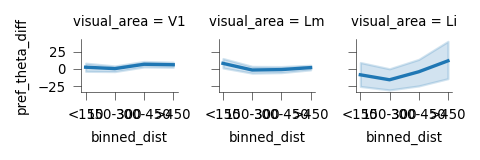

In [1435]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=fitdist, height=1)
fg.map(sns.lineplot, 'binned_dist', metric)

In [1436]:
# fitdist['abs_diff_rad'] = [np.deg2rad(i) for i in fitdist['abs_diff'].values]

# fitdist['binned_rad'] = [np.deg2rad(i) for i in fitdist['binned_theta'].values]

# print(fitdist['abs_diff_rad'].min(), fitdist['abs_diff_rad'].max())
# print(fitdist['binned_rad'].min(), fitdist['binned_rad'].max())
# fitdist.head()

In [1437]:
# Mean by FOV
mean_fitdist = fitdist.groupby(
                ['visual_area', 'datakey', 'binned_dist', 'binned_theta'])\
                .mean().reset_index().dropna()
mean_fitdist.head()
# cols = ['visual_area', 'datakey', 'binned_dist', 'binned_rad', 'abs_diff_rad']
# groups = ['visual_area', 'datakey', 'binned_dist', 'binned_rad']
# mean_fitdist = fitdist[cols].groupby(groups)\
#                         .apply(spstats.circmean, 
#                         high=np.pi, low=0, nan_policy='omit').reset_index()\
#                         .rename(columns={0: 'abs_diff_rad'})
# mean_fitdist['abs_diff'] = [np.rad2deg(i) for \
#                                     i in mean_fitdist['abs_diff_rad'].values]
# mean_fitdist['binned_theta'] = [np.rad2deg(i) for \
#                                     i in mean_fitdist['binned_rad'].values]

,visual_area,datakey,binned_dist,binned_theta,cell_1,cell_2,signal_cc,noise_cc,cortical_distance,pref_theta_diff,abs_diff
40,Li,20190314_JC070_fov1,<150,-180.0,297.0,318.0,0.050655,0.433490,107.332928,-176.326531,176.326531
41,Li,20190314_JC070_fov1,<150,-140.0,279.0,297.0,-0.149087,-0.083493,107.157176,-154.285714,154.285714
43,Li,20190314_JC070_fov1,<150,-60.0,218.0,253.0,0.293214,0.181292,101.372948,-51.428571,51.428571
44,Li,20190314_JC070_fov1,<150,-20.0,254.0,270.5,0.541135,0.144238,93.358755,-18.367347,18.367347
51,Li,20190314_JC070_fov1,150-300,-140.0,211.0,259.5,-0.128815,0.023185,271.443274,-154.285714,154.285714


In [1438]:
# d_=[]
# for (va, dk, b_dist, b_theta), g in fitdist.groupby(
#         ['visual_area', 'datakey', 'binned_dist', 'binned_theta']):
#     cells_in_bin = np.union1d(g['cell_1'].unique(), g['cell_2'].unique())
#     df_ = pd.DataFrame({'cell': cells_in_bin})
#     df_['visual_area'] = va
#     df_['datakey'] = dk
#     df_['binned_dist'] = b_dist
#     df_['binned_theta'] = b_theta
#     d_.append(df_)
# cells_in_bin = pd.concat(d_)

In [1439]:
# meanfit = fitdist.groupby(
#             ['visual_area', 'datakey', 'binned_dist'])['abs_diff']\
#             .mean().dropna().reset_index()
# meanfit.groupby(['visual_area', 'binned_dist']).mean()

<IPython.core.display.Javascript object>


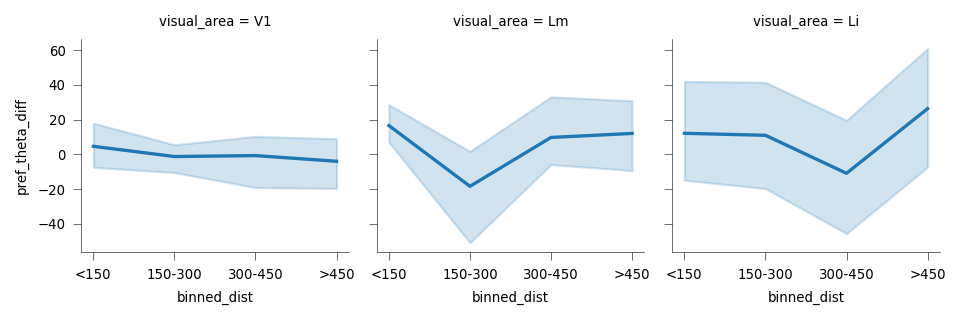

In [1440]:
meanfit = fitdist.groupby(
            ['visual_area', 'datakey', 'binned_dist'])[metric]\
            .mean().dropna().reset_index()
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=meanfit, height=2)
fg.map(sns.lineplot, 'binned_dist', metric)

In [1441]:
counts = fitdist.groupby(['visual_area', 'binned_dist', 'binned_theta'])\
            ['neuron_pair'].count().reset_index()\
        .rename(columns={'neuron_pair': 'n_theta_bin'})
counts
counts['n_dist_bin'] = None
for (va, bd), g in counts.groupby(['visual_area', 'binned_dist']):
    counts.loc[g.index, 'n_dist_bin'] = g['n_theta_bin'].sum()
counts['fraction'] = counts['n_theta_bin'] / counts['n_dist_bin'].astype(float)

<IPython.core.display.Javascript object>


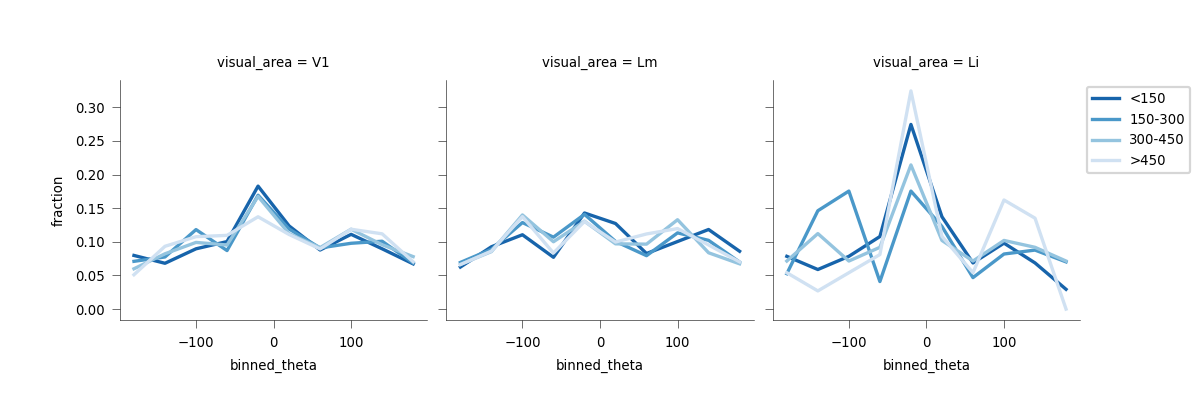

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

In [1442]:
dist_c = sns.color_palette('Blues_r', n_colors=len(dist_labels))
dist_colors = dict((k, v) for k, v in zip(dist_labels, dist_c))

#{'<150': 'b', '150-300': 'g', '300-450': 'r', '>450': 'k'}
plotd = counts.copy() #[counts['binned_dist']!='>450']
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=plotd,
                  height=2.5)
fg.map(sns.lineplot, 'binned_theta', 'fraction', 'binned_dist',
      palette=dist_colors)

pl.legend(loc='upper left', bbox_to_anchor=(1,1))
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

<IPython.core.display.Javascript object>


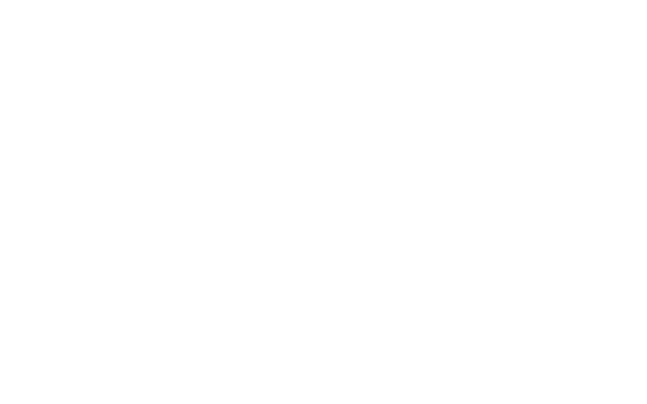

Text(0.0, 0.95, 'Common to RFs/gratings (GoF=0.50)')

In [31]:
gof_thr=0.5
# if pass_gof:
#     plotd = finaldf[finaldf['gof']>gof_thr].copy().dropna()
# else:
plotd = finaldf.copy()
rf_color='k'
ori_color='cornflowerblue'
ell_icon_height = 5
alpha=0.5
bar_width=15.
bin_size = 10
# -----------------------------------------
max_ori = 360.
ori_names = np.arange(0, max_ori+45, 45)
ori_bins = np.arange(0, max_ori+bin_size, bin_size)

rf_names = np.arange(-90, 90+45, 45)
rf_bins = np.arange(-90, 90+bin_size, bin_size)
# plot.
fig = pl.figure(figsize=(8,5))
i=0
for vi, visual_area in enumerate(visual_areas):
    g = plotd[plotd['visual_area']==visual_area].copy()
    # First, do PREFERRED THETA
    degrees = g['theta_pref'].values % max_ori #% 180.
    radians = np.rad2deg(degrees)
    bin_counts, bin_vals = np.histogram(degrees, bins=ori_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax = pl.subplot(2, 3, vi+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
               facecolor=ori_color, alpha=0.7, edgecolor="none", 
               color=ori_color, linewidth=0.5)
    ax.set_title('%s' % (visual_area), loc='center', fontsize=12, y=1.2)
    ax.text(ax.get_xlim()[0], ax.get_ylim()[-1]*1.3, 
            '(n=%i cells)' % g.shape[0], fontsize=6, horizontalalignment='center')
    # Set ticks
    ax.set_theta_zero_location("N")
    ax.set_rlabel_position(45)
    ori_names = np.arange(0, 360, 45) #np.rad2deg(xticks)
    pplot.replace_ori_labels(ori_names, ax=ax, 
                    xybox=(0, 0), yloc=ax.get_ylim()[-1]*1.1, zoom=0.12, polar=True)
    ax.set_yticks(np.linspace(0, round(ax.get_ylim()[-1]), 4))
    #ax.set_yticklabels([])
    # Now, do RECEPTIVE FIELD angles
    degrees = np.rad2deg(g['theta_Mm_c'].values) #. #- 90.
    bin_counts, bin_vals = np.histogram(degrees, bins=rf_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax = pl.subplot(2, 3, vi+3+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
           color=rf_color, alpha=0.5, edgecolor=rf_color, lw=0.5)
    ax.set_theta_zero_location("N")
    # Set ticks
    ax.set_xlim([-np.pi/2., np.pi/2.])
    ax.set_xticks(np.arange(-np.pi/2., np.pi/2. + (np.pi/4.), np.pi/4.))
    ax.set_yticks(np.linspace(0, round(ax.get_ylim()[-1]), 4))
    #ax.set_yticklabels([])
    yloc = ax.get_ylim()[-1]*1.1 # + 4
    pplot.replace_rf_labels(rf_names, ax=ax, alpha=alpha,
                    width=ell_icon_height*2., height=ell_icon_height, color='k', 
                    yloc=yloc, lw=1, box_alignment=(1, 1), 
                    xybox=(-ell_icon_height/2., 1))
    i+=2
pplot.label_figure(fig, data_id)
pl.subplots_adjust(left=0.15, wspace=0.5, hspace=0.2, top=0.8,
                   right=0.95, bottom=0.1)

fig.text(0.05, 0.85, "Pref. thetas", horizontalalignment='left', fontsize=6)
fig.text(0.05, 0.4, "R.F. angles", horizontalalignment='left', fontsize=6)
fig.text(0.0, 0.95, "Common to RFs/gratings (GoF=%.2f)" % gof_thr, 
             horizontalalignment='left', fontsize=8)

# figname = 'polar_theta_v_RFangles__gof%.2f_%s' % (gof_thr, dset_str)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

In [ ]:
def split_by_angle(df_, bin_value, metric='theta_Mm_deg', 
                   boundary_value=180, bin_size=45, combine_zero=True):
    
    ori_bins = np.arange(-boundary_value, boundary_value+bin_size, bin_size)
        
    #angles = (degs + 180.) % (2*180.) - 180.
    half_bin = bin_size/2.

    if bin_value == -boundary_value:
        bmin = boundary_value - half_bin # 90 - 22.5
        bmax = -boundary_value + half_bin  # -90 + 22.5 
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric]<=bmax]
            #n_in_bin = len(angles[angles<=bmax])
    elif bin_value == boundary_value:
        bmin = boundary_value - half_bin
        bmax = -boundary_value + half_bin
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric] >= bmin]
            #n_in_bin = len(angles[angles>=bmin])
    else:
        bmin = bin_value - half_bin
        bmax = bin_value + half_bin
        curr_vs = df_[ (df_[metric] >= bmin) & (df_[metric] <= bmax) ]
        #n_in_bin = len(angles[(angles >= bmin) & (angles<=bmax)])

    #n_in_bin = np.where([angles<])
    #bin_counts.append(n_in_bin)

    return curr_vs #bin_counts, ori_bins

In [ ]:
rf_color='k'
ori_color='cornflowerblue'

plotd = finaldf.copy()
yloc=0.5
rf_bin_size = 45
rf_boundary_value = 90 #np.pi/2.
rf_bins = np.arange(-rf_boundary_value, rf_boundary_value + rf_bin_size, rf_bin_size) #% 180.
rf_bin_span=22.5 #22.5 #.5 #22.5
rf_theta_param = 'rf_theta_deg' #'theta_deg'
##### 
bar_width=30
ori_bin_span=22.5 #2.5 #22.5 #22.5
####
aniso_thr=0.1
filter_aniso=False
max_ori=360.
mod_val=360.
n_bins_dist = 8 if max_ori==360. else 4
ori_bins = np.arange(-180, 180+45, 45)
ori_names = np.arange(0, max_ori+45, 45)
label_unit='degrees'
# =====================================================
# PLOT
# =====================================================
fig, axn = pl.subplots(3, len(rf_bins)-1, figsize=(8,6),sharex=True)
pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8, left=0.11, right=0.95)
offset=0.25
for va, df_ in plotd.groupby(['visual_area']):
    vi = visual_areas.index(va) #vi, va in enumerate(visual_areas):
    #df_ = DF[(DF['visual_area']==va)].copy()
    print('%s:: %i cells' % (va, df_.shape[0]))
    if filter_aniso:
        df_ = df_[df_['anisotropy']>=aniso_thr] #.copy()
    for ci, currbin in enumerate(rf_bins[::-1][0:-1]):   
        # Get all cells with RF angle CURRBIN
        # ---------------------------------------------------------------------
        curr_vs = split_by_angle(df_, currbin, metric=rf_theta_param, 
                                 boundary_value=rf_boundary_value, 
                                 bin_size=rf_bin_span, combine_zero=True)
        if curr_vs.shape[0]==0:
            continue   
        ncells = curr_vs.shape[0]
        # Calculate distn of prefered OSI 
        # ---------------------------------------------------------------------
        pref_theta_deg = curr_vs['tested_theta'].values % mod_val
        # RF hists of value
        # ---------------------------------------------------------------------
        ax=axn[vi, ci]
        ax.set_title("%s (%i, %i)" % (va, vi, ci))        
        xticks = np.arange(0, mod_val+45, 45)
        if len(pref_theta_deg)==1:
            ax.plot(pref_theta_deg, yloc, color=ori_color, marker='*')
        #ax.hist(pref_theta_deg % mod_val, bins=xticks, align='mid', color='gray', alpha=0.5)
        sns.histplot(pref_theta_deg, ax=ax, bins=n_bins_dist, 
                    color=ori_color,
                    kde=True, stat='count', lw=.25, binrange=(0, 360))

        bwidth = np.mean(np.ediff1d(xticks))/2.
        line_loc = ((currbin+90)%360)+bwidth
        ax.axvline(x=line_loc, color='k', lw=0.5, ls=':')
        ax.axvline(x=(line_loc+180)%360., color='k', lw=0.5, ls=':')
        centers = np.ediff1d(xticks)//2 + xticks[:-1]
        ax.set_xticks(centers)
        #ax.set_xticklabels([int(i) for i in xticks], fontsize=4)
        pplot.replace_ori_labels(xticks, bin_centers=centers, ax=ax, xybox=(0, -0.1), 
                           yloc=-0.15, zoom=0.1, polar=False)
        ax.tick_params(which='both', axis='both', labelsize=6, size=2)
        # RF shapes
        # ---------------------------------------------------------------------
        rect = [0.0, 0.69, 0.28, 0.3]
        ax1 = pplot.add_subplot_axes(ax, rect, axisbg='white', axis_alpha=0.5)
        ax1.set_xlim([-12, 12])
        ax1.set_ylim([-12, 12])
        mean_rf_theta = np.rad2deg(np.mean(abs(curr_vs['theta_Mm_c'].values)))
        for ri in curr_vs.index.tolist():
            rv = curr_vs.loc[ri]
            (sz_x, sz_y, th) = rv[['major_axis', 'minor_axis', 'theta_Mm_c']].values
            #(sz_x, sz_y, th) = rv[['std_x', 'std_y', 'theta']].values
            ell = mpl.patches.Ellipse((0, 0), abs(sz_x), abs(sz_y), angle=np.rad2deg(th), edgecolor=rf_color, 
                          facecolor='none', alpha=0.5, lw=0.25)
            ax1.add_patch(ell)
        ax1.set_aspect('equal')
        #ax1.set_title('avg. RF=%.1f deg' % (mean_rf_theta), loc='center', fontsize=6)
        pplot.turn_off_axis_ticks(ax1, despine=False)
        ax.set_title('%s) RF bin %i deg (n=%i cells)' % (va, currbin, ncells), fontsize=6)
        ax.set_xlim([-45, 360+45])
    fig.text(0.05, 0.8-(vi*offset), va)

fig.text(0.05, 0.9, "Pref theta distNs, by RF angle")
pplot.label_figure(fig, data_id)
    
# figname = 'hist_RFangle_vs_preferredtheta_gof%.2f_%s' % (gof_thr, dset_str)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

# print(curr_dst_dir, figname)